# Advanced Encoding: Using Model-Derived Representations of Naturalistic Stimuli to Encode Brain Data

The predictors formerly used to predict brain activations were limited.
They were manually-designed features and therefore, many dimensions of the input could not be taken into account.

For example, we could encode:


* perceptual features (is there a human in each frame? when watching a movie)
* the current word (when listening to a story)

BUT more complex information such as:

* the context in which these perceived objects usually occur,
* the probability distribution of the possible following words,
* etc...

cannot be easily encoded manually.

That's why we want to use tools that can build rich and complex representations of the stimuli.

This is where Machine Learning models arrive !


### Hypothesis:

If a given brain region is well predicted by the features derived from a machine learning model, this suggests that there is a high probability that the information encoded by this voxel and the information encoded by the model are similar.


### Downloading the encoding repository

In [ ]:
!git clone https://github.com/AlexandrePsq/main_tutorial.git

### Downloading the required packages

In [ ]:
!pip install -r requirements.txt
!pip install -e .

### Loading fMRI data and Stimuli

We load the fMRI data of a subject that has listened to an episode of Friends (season 2), the associated subtitles and the timestamp at which each word in the subtitles occured.

"**ATTENTION!!!**
To gain access to the fMRI data, please fill out this [short form](https://docs.google.com/forms/d/e/1FAIpQLSeC68uQA5sBxowTA-vYU8V-MOaKP1QRBOU_EJxGm3lIi4Te-A/viewform?usp=share_link) and follow the instructions in the end."

In [1]:
from src.data import load_fmri_data, load_stmuli, fetch_masker

stimuli_url = "https://drive.google.com/uc?id=1TbV2refDKYI_uZ1Ff0sk6U7gxX-5vQYM&export=download"
fmri_url = "FILL THE LINK HERE" 

# Fetch fmri and stimuli data
fmri_data = load_fmri_data(fmri_url, download=False, template='./data/fMRI/')
stimuli_data = load_stmuli(stimuli_url, download=False, template='./data/gentle_files/')


/Applications/anaconda3/envs/parietal/lib/python3.7/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


### Visualizing fMRI data

We visualize the 6-th image of the first fMRI file (taken from fmri_data):

/Applications/anaconda3/envs/parietal/lib/python3.7/site-packages/nilearn/glm/__init__.py:56: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  'It may change in any future release of Nilearn.', FutureWarning)


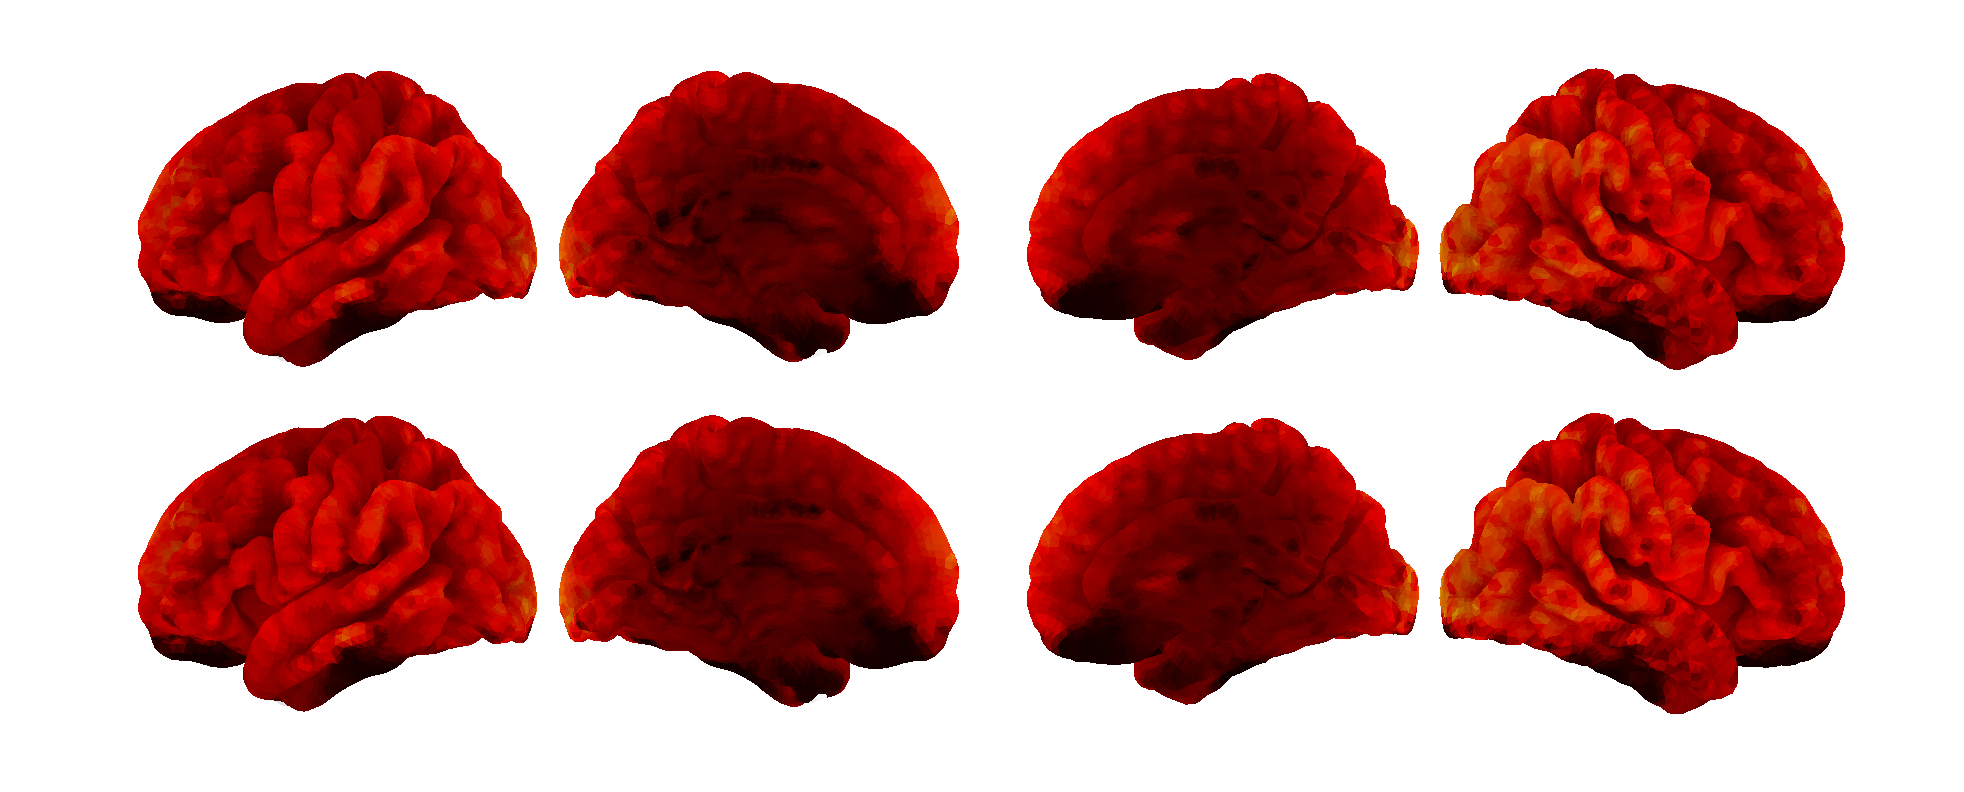

In [7]:
import numpy as np
import nibabel as nib
from nilearn import image
from src.plotting import pretty_plot

imgs = [image.index_img(nib.load(fmri_data[0]), 5), image.index_img(nib.load(fmri_data[0]), 100)]
vmax = np.max(imgs[0].get_fdata())

pretty_plot(
    imgs, 
    zmaps=None, 
    masks=None,
    names=['img-5', 'img-100'],
    ref_img=None,
    vmax=vmax, 
    cmap='cold_hot',
    saving_folder='../derivatives/', 
    plot_name='First_Image',
    row_size_factor=6,
    overlapping=6,
    column_size_factor=8,
    )

This data is volumic and include many point outside brain volume. You want to filter them out.

To do so you use a NiftiMasker object that transforms your NifitImage into a numpy array, keeping only voxels of interest (where there is enough signal).

In [33]:
fmri_data = fmri_data[:4]
stimuli_data = stimuli_data[:4]

In [2]:
from src.data import load_fmri_data, load_stmuli, fetch_masker, preprocess_fmri_data, preprocess_stimuli_data

# Fetch or create a masker object that retrieve the voxels of interest in the brain
masker = fetch_masker('./derivatives/masker', fmri_data, **{'detrend': True, 'standardize': True})

# Process fmri data with the masker
fmri_data = preprocess_fmri_data(fmri_data, masker)
stimuli_data = preprocess_stimuli_data(stimuli_data)

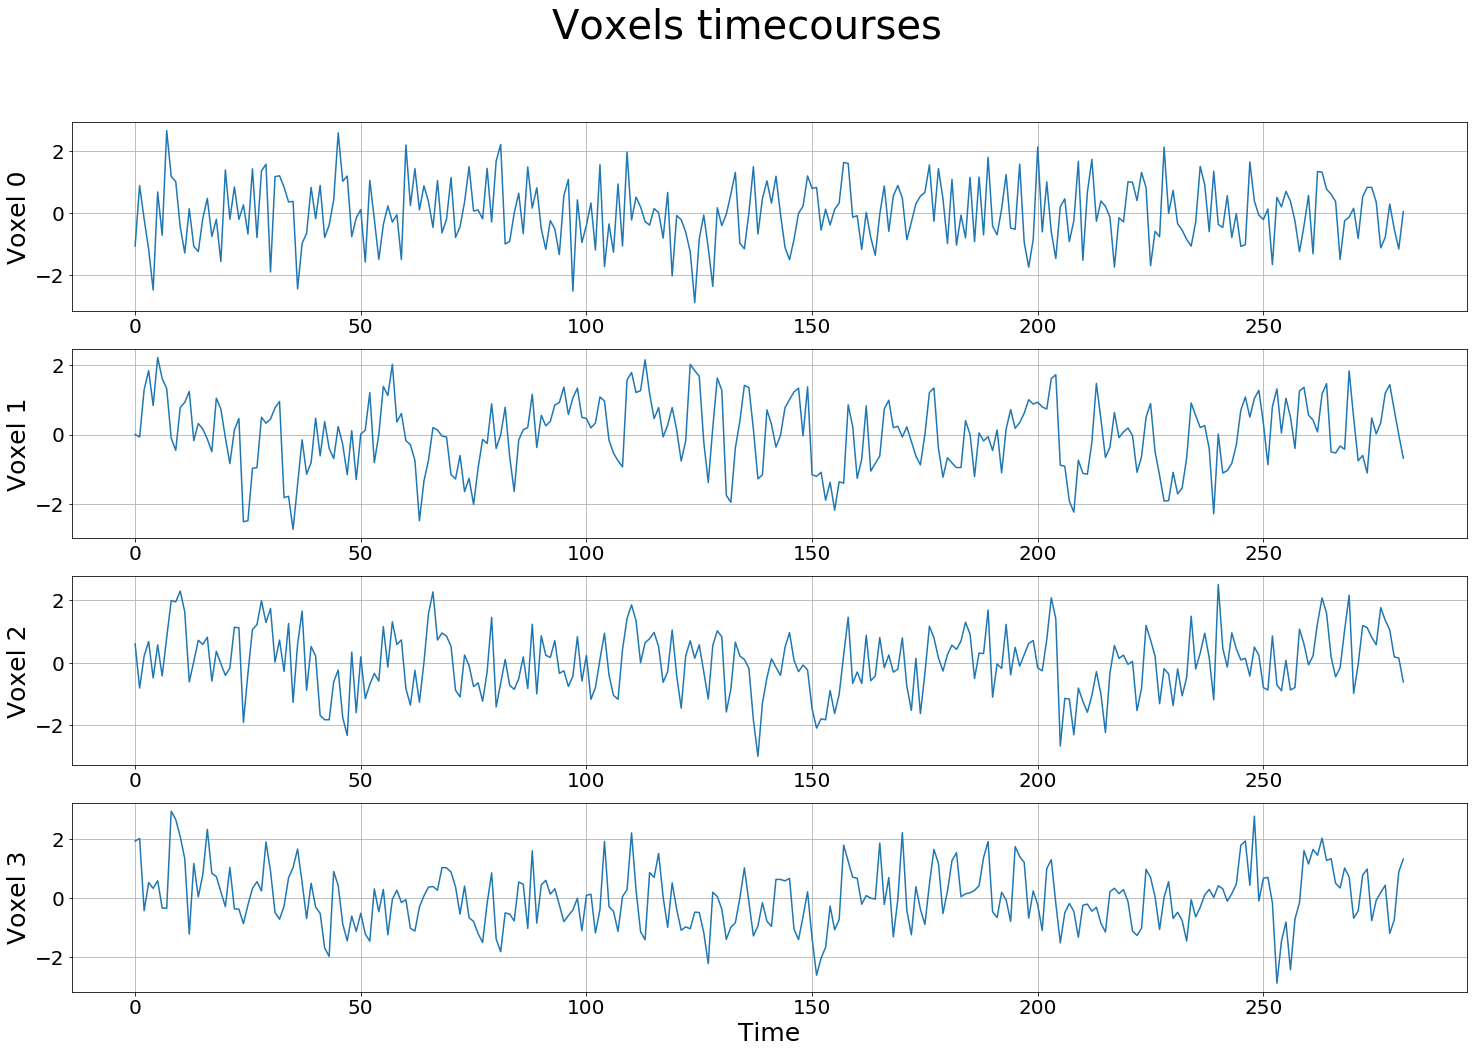

In [3]:
# Visualizing voxels time-course
import matplotlib.pyplot as plt
nb_voxels = 4
fig, axs = plt.subplots(nb_voxels, 1, figsize=(25, nb_voxels*4))
for i in range(nb_voxels):
    axs[i].plot(fmri_data[0][:, i])
    axs[i].grid(True)
    axs[i].tick_params(axis='both', which='major', labelsize=20)
    axs[i].tick_params(axis='both', which='minor', labelsize=20)
    axs[i].set_ylabel(f'Voxel {i}', fontsize=25)
axs[nb_voxels-1].set_xlabel('Time', fontsize=25)
plt.suptitle('Voxels timecourses', fontsize=40)
plt.show()

In [3]:
import nibabel as nib
import pandas as pd
import numpy as np

print(f'There are {len(fmri_data)} files of fMRI data.')
print(f'Of sizes: {[i.shape for i in fmri_data]}')

print(f'There are {len(stimuli_data)} files of stimuli data.')
print(stimuli_data[0].head())

There are 9 files of fMRI data.
Of sizes: [(282, 26721), (298, 26721), (340, 26721), (303, 26721), (265, 26721), (343, 26721), (325, 26721), (292, 26721), (368, 26721)]
There are 9 files of stimuli data.
   Word     Onset    Offset
0  once  0.113200  0.728200
1  when  0.728200  0.919408
2     i  0.919408  1.024887
3   was  1.024887  1.158200
4   six  1.158200  1.464064


## Extracting Features

### GloVe

In [4]:
import os, gdown
from tqdm import tqdm

# Downloading GloVe Model
trained_model = './data/glove.6B.300d.txt'
if not os.path.exists(trained_model):
    url = "https://nlp.stanford.edu/data/glove.6B.zip"
    output = './data/glove.zip'
    gdown.download(url, output, quiet=False)
    os.system(f'unzip {output} -d ./data/')

# Create the GloVe model which is a dictionary from the loaded file
glove_model = {}
with open(trained_model, 'r', encoding="utf-8") as f: 
    for line in tqdm(f): 
        values = line.split() 
        word = values[0] 
        vector = np.asarray(values[1:], "float32") 
        glove_model[word] = vector 

print(f"The vector associated with ‘the‘ has the size: {glove_model['the'].size}")

400000it [00:21, 19002.32it/s]

The vector associated with ‘the‘ has the size: 300


In [5]:
import pandas as pd

from src.models import extract_glove_features

# Here we just add some words unseen during training ... (i manually set the representations of unseen words to the one
# of a close match, or the average of several word representations)
glove_model = extract_glove_features.update_model(glove_model, embedding_size=300)

features_glove = []
FEATURE_COUNT = 300 # glove representation are vectors of size 300
for s in stimuli_data:
    words = s['Word'].values
    features = []
    columns = ['embedding-{}'.format(i) for i in range(1, 1 + FEATURE_COUNT)]
    features = []
    for item in tqdm(words):
        if item not in glove_model.keys():
            print(item)
            item = '<unk>'
        features.append(glove_model[item])
    features = pd.DataFrame(np.vstack(features), columns=columns)
    features_glove.append(features)
print(features_glove[0].head())

100%|██████████| 1978/1978 [00:00<00:00, 1902392.41it/s]

   embedding-1  embedding-2  embedding-3  embedding-4  embedding-5  \
0    -0.137340     0.270770      0.11504    -0.061770     0.447820   
1    -0.141540     0.027303      0.13594    -0.120160     0.316880   
2    -0.132920     0.169850     -0.14360    -0.088722     0.079510   
3     0.065573     0.022011     -0.13182    -0.213300    -0.045275   
4    -0.381010     0.361330     -0.38945     0.029712     0.013657   

   embedding-6  embedding-7  embedding-8  embedding-9  embedding-10  ...  \
0    -0.000406     0.303950    -0.034915     0.155100      -1.56480  ...   
1    -0.002833     0.049514     0.012035     0.050774      -1.78970  ...   
2    -0.142120    -0.024209    -0.262910    -0.074814      -2.36000  ...   
3    -0.095786    -0.197060     0.008206    -0.292850      -1.82300  ...   
4     0.108140    -0.161550    -0.034614    -0.002563      -0.94856  ...   

   embedding-291  embedding-292  embedding-293  embedding-294  embedding-295  \
0      -0.064396       0.069029      -0.12

In [6]:
## --> Do the entire stuff quickly <--
## Load the GloVe model
#from models import extract_glove_features
#gpt2_model, tokenizer = extract_glove_features.load_glove_model()
#
## Extracting features with GloVe
#features_glove = [
#    extract_glove_features.extract_features(
#        s['word'].values, 
#        glove_model, 
#        FEATURE_COUNT=768,
#        ) for s in stimuli_data
#    ] # list of pandas DataFrames
#

In [7]:
features_glove = [df.values for df in features_glove]

### GPT-2

In [9]:
from src.models import extract_gpt2_features

# Loading GPT-2 Model
gpt2_model, tokenizer = extract_gpt2_features.load_model_and_tokenizer('gpt2')

In order to retrieve the fetaures from the model, several preprocessing steps can be applied.
In our case, we want the embedding for each word.

The tokenizer can split a word into several tokens. We first need to learn the association between a word and the tokens it is split into.

We tokenize the text and learn the mapping:

In [10]:

words = stimuli_data[0]['Word'].values
sample_words = words[:100]
iterator = ' '.join(sample_words)

print('Example of stimuli sample given to the model:')
print(' '.join(sample_words), '\n')

tokenized_text = tokenizer.tokenize(iterator)
print(f'Tokenized text: \n{tokenized_text}\n')
mapping = extract_gpt2_features.match_tokenized_to_untokenized(tokenized_text, iterator)
print(f'We learn how a given word is separated into several tokens: \n{mapping}')


Example of stimuli sample given to the model:
everybody shh shh central perk is proud to present the music of miss phoebe buffay hi i want to start with a song that's about that moment when you suddenly realize what life is really all about okay here we go okay thank you very much what the oh great this is just wow this is so cool the entire city is blacked out mom says it's all of manhattan parts of brooklyn and queens and they have no idea when it's coming back on guys this is big pants and a sweater why mom who am i going to 

Tokenized text: 
['every', 'body', 'Ġsh', 'h', 'Ġsh', 'h', 'Ġcentral', 'Ġperk', 'Ġis', 'Ġproud', 'Ġto', 'Ġpresent', 'Ġthe', 'Ġmusic', 'Ġof', 'Ġmiss', 'Ġph', 'oe', 'be', 'Ġbuff', 'ay', 'Ġhi', 'Ġi', 'Ġwant', 'Ġto', 'Ġstart', 'Ġwith', 'Ġa', 'Ġsong', 'Ġthat', "'s", 'Ġabout', 'Ġthat', 'Ġmoment', 'Ġwhen', 'Ġyou', 'Ġsuddenly', 'Ġrealize', 'Ġwhat', 'Ġlife', 'Ġis', 'Ġreally', 'Ġall', 'Ġabout', 'Ġokay', 'Ġhere', 'Ġwe', 'Ġgo', 'Ġokay', 'Ġthank', 'Ġyou', 'Ġvery', 'Ġmuch',

Another issue is that when giving a sentence to the model, the representation of each token is built using all the previous words.
Therefore, the more a token is far in the sentence the more context it can leverage.

In order for the tokens to access a similar amount of context, we design our input in the following fashion:

In [11]:
context_size = 50    # number of tokens before each token for which we retrieve the embedding vector
max_seq_length = 512  # maximum input size that can be given to the model
space='Ġ'             # specific to the tokenizer...
special_token_beg='<|endoftext|>' # special tokens added at the beginning of the sentence specific to the tokenizer...
special_token_end='<|endoftext|>' # special tokens added at the end of the sentence specific to the tokenizer...


input_ids, indexes, tokens = extract_gpt2_features.batchify_to_truncated_input(
    iterator, tokenizer, 
    context_size=context_size, 
    max_seq_length=max_seq_length, 
    space=space, 
    special_token_beg=special_token_beg, 
    special_token_end=special_token_end)

print('Model input: \n', input_ids)
print()
print(f'The input size is: {input_ids.shape}')
print()
print('Positions of the tokens for which we retrieve the embedding vector: \n', indexes)

Model input: 
 tensor([[50256, 16833,  2618,  ...,   845,   220, 50256],
        [50256,  2618,   427,  ...,   881,   220, 50256],
        [50256,   427,    71,  ...,   644,   220, 50256],
        ...,
        [50256, 28796,   428,  ...,  1016,   220, 50256],
        [50256,   428,   318,  ...,   284,   220, 50256],
        [50256,   318,   523,  ...,   220, 50256,   220]])

The input size is: torch.Size([63, 55])

Positions of the tokens for which we retrieve the embedding vector: 
 [(1, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (

We regroup everythin into the following function:

In [12]:
# Extracting features with GPT-2
features_gpt2 = [
    extract_gpt2_features.extract_features(
        s['Word'].values, 
        gpt2_model, 
        tokenizer,
        bsz=32, # reduce bsz to 16 (or even to 8) if you have memory issue
        FEATURE_COUNT=768,
        NUM_HIDDEN_LAYERS=12,
        ) for s in stimuli_data
    ] # list of pandas DataFrames

features_gpt2 = [df.values for df in features_gpt2]

Token indices sequence length is longer than the specified maximum sequence length for this model (1352 > 1024). Running this sequence through the model will result in indexing errors
100%|██████████| 32/32 [04:48<00:00,  9.02s/it]


### Training the encoding model

Defining the different split for the Cross-validation:

In [8]:
features_gpt2 = features_glove.copy()

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split, LeavePOut

from src.utils import get_groups

out_per_fold = 1 
splits = []
logo = LeavePOut(out_per_fold)
gentles = [s['Offset'].values for s in stimuli_data]
nscans = [f.shape[0] for f in fmri_data] # number of scnas per session

for train, test in logo.split(features_glove):
    # Compute the number of rows in each run (= the number of samples extracted from the model for each run)
    gentles_train = [gentles[i] for i in train]
    groups_train = get_groups(gentles_train)

    gentles_test = [gentles[i] for i in test]
    groups_test = get_groups(gentles_test)
    # Preparing fMRI data
    
    
    splits.append({
        'fmri_train': [fmri_data[i] for i in train],
        'fmri_test': [fmri_data[i] for i in test],
        'features_glove_train': [features_glove[i] for i in train],
        'features_glove_test': [features_glove[i] for i in test],
        'features_gpt2_train': [features_gpt2[i] for i in train],
        'features_gpt2_test': [features_gpt2[i] for i in test],
        'groups_train': groups_train,
        'nscans_train': [nscans[i] for i in train],
        'gentles_train': gentles_train,
        'groups_test': groups_test,
        'nscans_test':[nscans[i] for i in test],
        'gentles_test': gentles_test,
    })


We instantiate the encoding model:

In [10]:
from src.encoder import Encoder
from src.ridge import CustomRidge

fmri_ndim = None
features_ndim = None
features_reduction_method = None #'pca'
fmri_reduction_method = None
tr = 1.49
encoding_method = 'hrf'
linearmodel = 'ridgecv'

encoder = Encoder(
    linearmodel=linearmodel, 
    features_reduction_method=features_reduction_method, 
    fmri_reduction_method=fmri_reduction_method, 
    fmri_ndim=fmri_ndim, 
    features_ndim=features_ndim, 
    encoding_method=encoding_method, 
    tr=tr
    )

/Applications/anaconda3/envs/parietal/lib/python3.7/site-packages/nilearn/glm/__init__.py:56: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  'It may change in any future release of Nilearn.', FutureWarning)


For each split we fit the encoding model for glove and for GPT-2 on the train set, and evaluate it on the test set:

In [ ]:
scores = {'glove': [], 'gpt2': []}
for i, split in tqdm(enumerate(splits)):
    fmri_train = np.vstack(split['fmri_train'])
    fmri_test = np.vstack(split['fmri_test'])
    features_glove_train = np.vstack(split['features_glove_train'])
    features_glove_test = np.vstack(split['features_glove_test'])
    features_gpt2_train = np.vstack(split['features_gpt2_train'])
    features_gpt2_test = np.vstack(split['features_gpt2_test'])

    groups_train = split['groups_train']
    nscans_train = split['nscans_train']
    gentles_train = split['gentles_train']

    groups_test = split['groups_test']
    nscans_test = split['nscans_test']
    gentles_test = split['gentles_test']

    # Fitting the model with GloVe
    encoder.fit(features_glove_train, fmri_train, groups=groups_train, gentles=gentles_train, nscans=nscans_train)
    encoder.set_features_pipe(features_glove_test, groups_test, gentles_test, nscans_test)
    pred = encoder.predict(features_glove_test)
    scores_glove = encoder.eval(pred, fmri_test)
    scores['glove'].append(scores_glove)

    # Fitting the model with GPT-2
    encoder.fit(features_gpt2_train, fmri_train, groups=groups_train, gentles=gentles_train, nscans=nscans_train)
    encoder.set_features_pipe(features_gpt2_test, groups_test, gentles_test, nscans_test)
    pred = encoder.predict(features_gpt2_test)
    scores_gpt2 = encoder.eval(pred, fmri_test)
    scores['gpt2'].append(scores_gpt2)



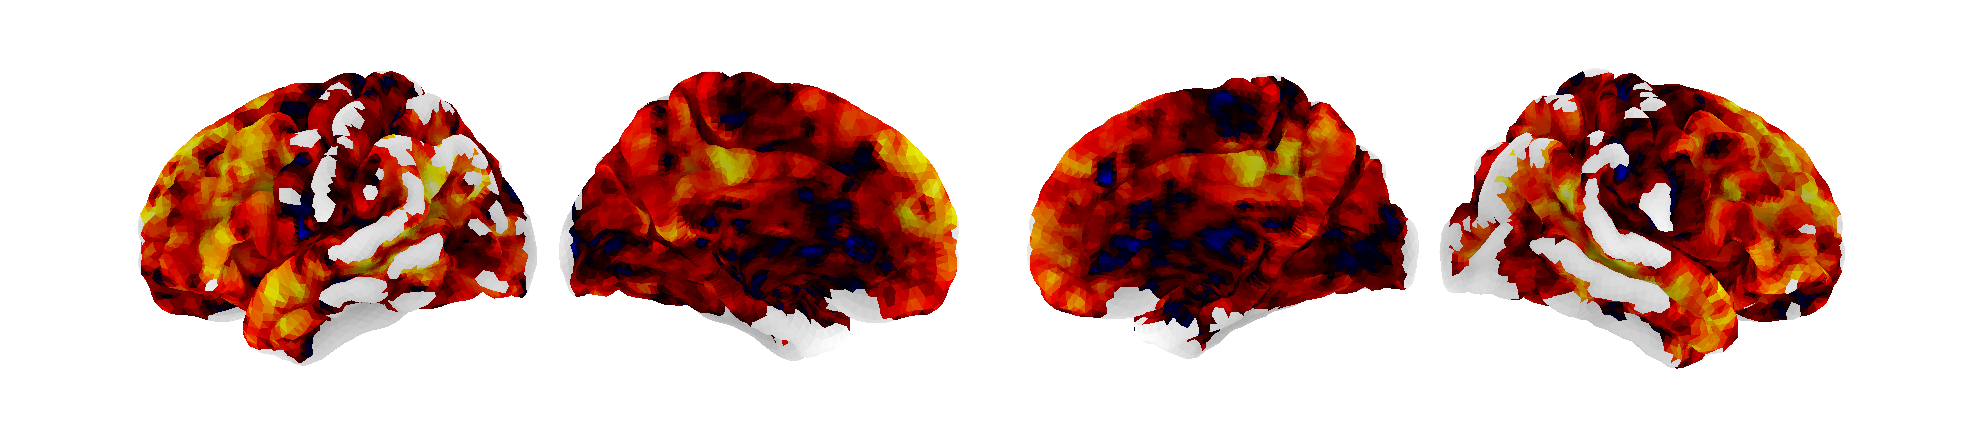

In [18]:
from src.plotting import pretty_plot

imgs = [np.mean([*scores['glove']], axis=0), np.mean([*scores['gpt2']], axis=0)]
imgs = [np.mean([*scores['glove']], axis=0)]
kwargs = {
            'detrend': False,
            'standardize': False,
        }
masker.set_params(**kwargs)
imgs = [masker.inverse_transform(img) for img in imgs]

zmaps = None
masks = None
names = ['GloVe'] # , 'GPT-2'

pretty_plot(
    imgs, 
    zmaps, 
    masks,
    names,
    ref_img=None,
    vmax=[0.35]*2, 
    cmap='cold_hot',
    hemispheres=['left', 'right'], 
    views=['lateral', 'medial'], 
    categorical_values=None, 
    inflated=False, 
    saving_folder='./derivatives/', 
    format_figure='pdf', 
    dpi=300, 
    plot_name='test',
    row_size_factor=6,
    overlapping=6,
    column_size_factor=8,
    )


In [22]:
scores = {'glove': [], 'gpt2': []}
for i, split in tqdm(enumerate(splits)):
    fmri_train = np.vstack(split['fmri_train'])
    fmri_test = np.vstack(split['fmri_test'])
    features_glove_train = np.vstack(split['features_glove_train'])
    features_glove_test = np.vstack(split['features_glove_test'])
    features_gpt2_train = np.vstack(split['features_gpt2_train'])
    features_gpt2_test = np.vstack(split['features_gpt2_test'])

    groups_train = split['groups_train']
    nscans_train = split['nscans_train']
    gentles_train = split['gentles_train']

    groups_test = split['groups_test']
    nscans_test = split['nscans_test']
    gentles_test = split['gentles_test']

    encoder = Encoder(
        linearmodel=CustomRidge(-3, 8, 10, nscans_train), 
        features_reduction_method=features_reduction_method, 
        fmri_reduction_method=fmri_reduction_method, 
        fmri_ndim=fmri_ndim, 
        features_ndim=features_ndim, 
        encoding_method=encoding_method, 
        tr=tr
        )

    # Fitting the model with GloVe
    encoder.fit(features_glove_train, fmri_train, groups=groups_train, gentles=gentles_train, nscans=nscans_train)
    encoder.set_features_pipe(features_glove_train, groups_train, gentles_train, nscans_train)
    X_train = encoder.features_pipe.fit_transform(features_glove_train)
    encoder.set_features_pipe(features_glove_test, groups_test, gentles_test, nscans_test)
    X_test = encoder.features_pipe.fit_transform(features_glove_test)

    Y_train = encoder.fmri_pipe.transform(fmri_train)
    Y_test = encoder.fmri_pipe.transform(fmri_test)

    R2_ = np.zeros((Y_test.shape[1]))
    Pearson_coeff_ = np.zeros((Y_test.shape[1]))
    coefs = np.zeros((Y_test.shape[1], X_test.shape[1]))
    intercepts = np.zeros((Y_test.shape[1]))
    diag_matrix = np.array([])

    for alpha_, voxels in encoder.encoding_pipe['linearmodel'].alpha2voxel.items():
        if voxels:
            y_test_ = Y_test[:, voxels]
            y_train_ = Y_train[:, voxels]

            encoder.encoding_pipe['linearmodel'].model_fit(X_train, y_train_, alpha_)
            predictions = encoder.encoding_pipe['linearmodel'].model.predict(X_test)
            R2_[voxels] = encoder.encoding_pipe['linearmodel'].get_R2_coeff(predictions, y_test_)
            Pearson_coeff_[voxels] = encoder.encoding_pipe['linearmodel'].get_Pearson_coeff(predictions, y_test_)
            coefs[voxels, :] = encoder.encoding_pipe['linearmodel'].model.coef_
            intercepts[voxels] = encoder.encoding_pipe['linearmodel'].model.intercept_
    result = {'R2': R2_,
                'Pearson_coeff': Pearson_coeff_,
                'alpha': encoder.encoding_pipe['linearmodel'].voxel2alpha,
                'coef_': coefs,
                'intercept_': intercepts,
                'diag_matrix': diag_matrix,
                }
    scores['glove'].append(result['Pearson_coeff'])


    #pred = encoder.predict(features_glove_test)
    #scores_glove = encoder.eval(pred, fmri_test)
    #scores['glove'].append(scores_glove)

    ## Fitting the model with GPT-2
    #encoder.fit(features_gpt2_train, fmri_train, groups=groups_train, gentles=gentles_train, nscans=nscans_train)
    #encoder.set_features_pipe(features_gpt2_test, groups_test, gentles_test, nscans_test)
    #pred = encoder.predict(features_gpt2_test)
    #scores_gpt2 = encoder.eval(pred, fmri_test)
    #scores['gpt2'].append(scores_gpt2)



RidgeCV(alpha_per_target=True,
        alphas=array([1.00000000e+01, 2.78255940e+01, 7.74263683e+01, 2.15443469e+02,
       5.99484250e+02, 1.66810054e+03, 4.64158883e+03, 1.29154967e+04,
       3.59381366e+04, 1.00000000e+05]),
        scoring='r2')

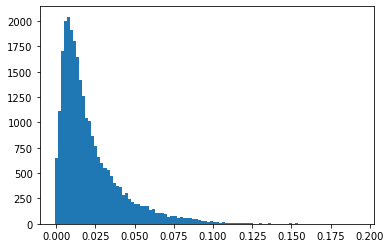

In [24]:
plt.hist(model.best_score_, bins=100)
plt.show()